This code is adapted from the link in the HW: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

We start with a pre processing stage 

In [32]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/English.txt', 'data/names/German.txt', 'data/names/Scottish.txt', 'data/names/Irish.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Polish.txt', 'data/names/Italian.txt', 'data/names/Czech.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Portuguese.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/French.txt']
Slusarski


we have created a dictionary of languages

In [33]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


We encode the characters as one hot vectors

In [34]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


This was the from scratch model on the website

In [35]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

This is the RNNCell version of it. it creates an RNNCell layer and then an output later so that once we reach the end of a sequence an output can be meaningfully generated

In [36]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)  # Use RNNCell
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = self.rnn_cell(input, hidden)  # Update hidden state
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)


Here I repeat the same process but with the RNN pytorch building block. Since it expects the input to be in batches and the website has a character by character training loop, I resized the data in the forward function to make use of the same training code.

In [37]:
# import torch
# import torch.nn as nn

# class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(RNN, self).__init__()

#         self.hidden_size = hidden_size

#         # RNN layer
#         self.rnn = nn.RNN(input_size, hidden_size)

#         # Output layer
#         self.h2o = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, input, hidden):
#         # Reshape input to (seq_len, batch, input_size)
#         input = input.view(1, 1, -1) #do this so it fits with the training loop that iterates per character

#         # Pass the input and hidden state to the RNN
#         output, hidden = self.rnn(input, hidden)

#         # Pass the output through the linear and softmax layers
#         output = self.h2o(output.view(1, -1))
#         output = self.softmax(output)

#         return output, hidden

#     def initHidden(self):
#         # Initialize hidden state with zeros
#         return torch.zeros(1, 1, self.hidden_size)

# # Example usage:
# n_hidden = 128
# rnn = RNN(n_letters, n_hidden, n_categories)


In [38]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [39]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish', 5)


In [40]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Polish / line = Rog
category = Russian / line = Emelyantsev
category = Spanish / line = D'cruze
category = Portuguese / line = Guerra
category = Korean / line = Nam
category = Arabic / line = Ghannam
category = Scottish / line = Ritchie
category = Japanese / line = Kunisada
category = Polish / line = Niemec
category = Russian / line = Mkrtchyants


The same training loop is used regardless of model

In [41]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

This loop was executed on all three models with the similar results. The current output is with the third RNN model (pytorch block)

In [42]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 15s) 2.3692 Vellansky / Greek ✗ (Russian)
10000 10% (0m 30s) 1.5768 Gordon / Scottish ✓
15000 15% (0m 45s) 1.3421 Mohan / Arabic ✗ (Irish)
20000 20% (0m 58s) 1.3414 Santos / Greek ✗ (Portuguese)
25000 25% (1m 10s) 0.7737 Yi / Korean ✓
30000 30% (1m 22s) 1.8368 Morales / Portuguese ✗ (Spanish)
35000 35% (1m 36s) 1.2401 Koemans / Dutch ✓
40000 40% (1m 51s) 1.9863 Leeuwenhoek / Polish ✗ (Dutch)
45000 45% (2m 5s) 0.1791 Freitas / Portuguese ✓
50000 50% (2m 18s) 2.8743 Michaud / Arabic ✗ (French)
55000 55% (2m 34s) 2.9788 Wilkinson / Scottish ✗ (English)
60000 60% (2m 47s) 0.1177 Mendes / Portuguese ✓
65000 65% (3m 1s) 1.0176 Albert / French ✓
70000 70% (3m 16s) 0.6881 Horiatis / Greek ✓
75000 75% (3m 29s) 2.4139 Paternoster / French ✗ (German)
80000 80% (3m 41s) 1.0936 Serak / Polish ✗ (Czech)
85000 85% (3m 54s) 0.2841 Rapallino / Italian ✓
90000 90% (4m 7s) 0.0303 Sardelis / Greek ✓
95000 95% (4m 20s) 6.3692 Degarmo / Italian ✗ (French)
100000 100% (4m 33s) 0.1587 Chou / Korea

The loss decreses rapidly and roughly begins to level out around 90-100 iterations meaning we picked a good number of iterations

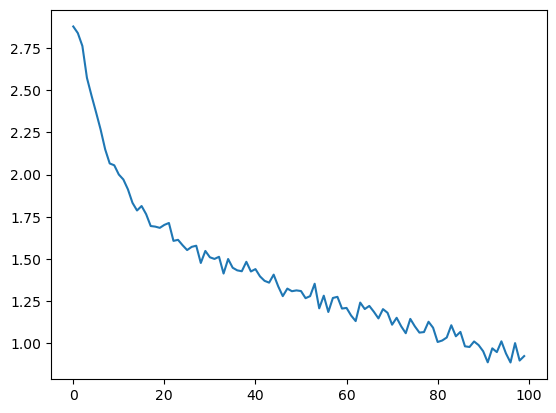

In [43]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Do you think using an LSTM instead of the vanilla RNN will improve the accuracy that the trained
network can reach? Justify very briefly.


Yes I think that an LSTM can improve accuracy as it can help with two things.

Firstly it helps with the vanishing gradient problems so we don't have to worry about the gradient disappearing as we increase iterations.

Secondly the propogation of "memory" through an LSTM is more robust and thus could help with accuracy

Here is the confusion matrix

/tmp/ipykernel_127567/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_127567/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


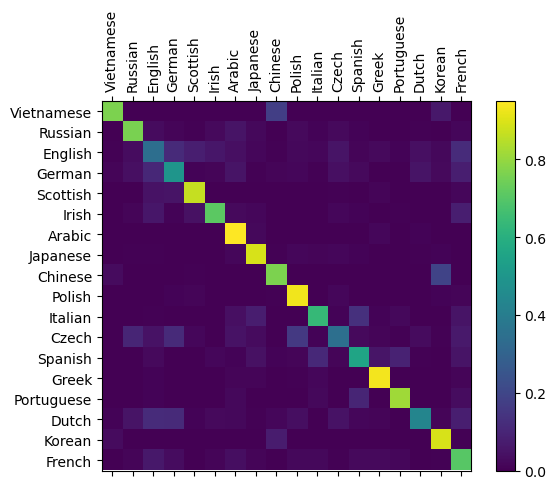

In [44]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [45]:
# Sum of diagonal elements (correct predictions)
correct_predictions = confusion.diag().sum()

# Total number of predictions
total_predictions = confusion.sum()

# Calculate accuracy
accuracy = correct_predictions / total_predictions

print(f'Accuracy: {accuracy.item()}')

Accuracy: 0.710720956325531
